Epoch 1/3000
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 859us/step - loss: 0.1868 - val_loss: 0.0905 - learning_rate: 0.0010
Epoch 2/3000
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 0.0678 - val_loss: 0.0638 - learning_rate: 0.0010
Epoch 3/3000
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 0.0603 - val_loss: 0.0665 - learning_rate: 0.0010
Epoch 4/3000
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 0.0587 - val_loss: 0.0866 - learning_rate: 0.0010
Epoch 5/3000
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 0.0524 - val_loss: 0.0573 - learning_rate: 0.0010
Epoch 6/3000
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 0.0487 - val_loss: 0.0625 - learning_rate: 0.0010
Epoch 7/3000
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 0.0514 - val_loss: 0.0756 - learning_rate: 0.0010
Epoch 8/3000
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 0.0443 - val_loss: 0.0551 - learning_rate: 0.0010
Epoch 9/3000
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 0.0453 - val_loss: 0.058

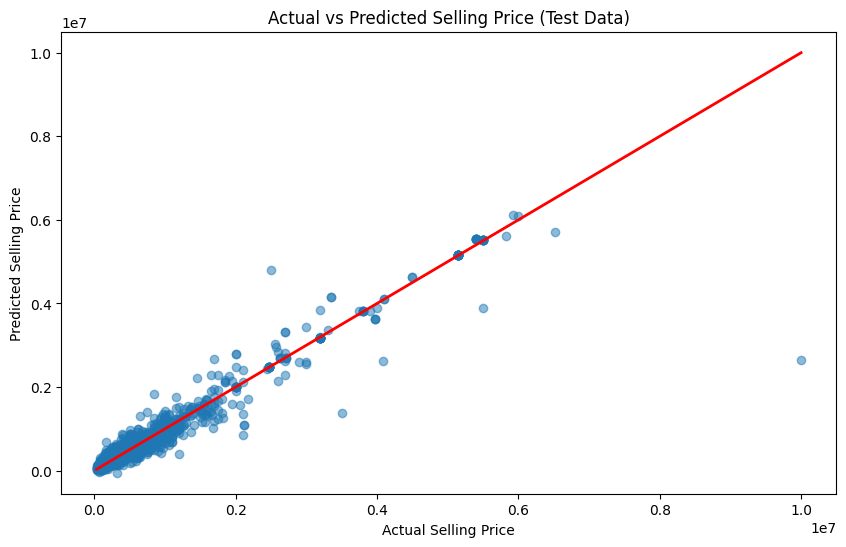

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import tensorflow as tf

# Load the car price dataset from a CSV file into a Pandas DataFrame 
df = pd.read_csv("Car details v3.csv")

# # Get basic information about data
# print(df.info())
# print(df.columns)

# Separate features (X) and target (y)
X = df[["year", "km_driven", "seller_type", "transmission", "owner", "mileage", "engine", "max_power", "seats"]].copy()
y = df[["selling_price"]]

# Extract numeric values from mileage, engine, and max_power columns and convert them to floats
for col in ["mileage", "engine", "max_power"]:
    X[col] = pd.to_numeric(
        X[col].astype(str).str.extract(r"(\d+\.?\d*)")[0],
        errors="coerce"
    )

# Separate numeric and categorical columns for preprocessing
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = X.select_dtypes(include=["object"]).columns

# Impute missing numeric values using the median of each column
for col in numeric_cols:
    X[col] = X[col].fillna(X[col].median())

# Impute missing categorical values using the most frequent category (mode)
for col in categorical_cols:
    X[col] = X[col].fillna(X[col].mode()[0])

# Split data into train (70%) and test (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define preprocessing pipeline: standardize numeric columns and one-hot encode categorical columns
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
    ],
    remainder="drop"
)

# Fit preprocessing on train data and apply the same transformation to both train and test datasets
X_train_scaled = preprocess.fit_transform(X_train)
X_test_scaled = preprocess.transform(X_test)

# Scaling the target variable to improve neural network training stability
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)

# Build a neural network model to predict car selling price
nn_model = tf.keras.Sequential([
    tf.keras.Input(shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(80, activation='relu',),
    tf.keras.layers.Dense(80, activation='relu',),
    tf.keras.layers.Dense(80, activation='relu',),
    tf.keras.layers.Dense(y_train_scaled.shape[1])
])

# Compile the neural network using Adam optimizer and Huber loss for regression
nn_model.compile(
    tf.keras.optimizers.Adam(learning_rate=0.001),
    # loss=tf.keras.losses.Huber(delta=100000.0),  # delta in INR
    loss='mse',
    # metrics=['mae']
)

# Reduce learning rate when validation loss stops improving
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=10, min_lr=1e-6
)

# Stop training early and restore the best model weights
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=30, restore_best_weights=True
)

# Train the neural network using validation split and adaptive callbacks
nn_model.fit(
    X_train_scaled, y_train_scaled,
    validation_split=0.2,
    shuffle=True,
    epochs=3000,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    #verbose=0
)

# Generate predictions for the train and test dataset
nn_model_prediction_train = nn_model.predict(X_train_scaled)
nn_model_prediction_test = nn_model.predict(X_test_scaled)

# Apply inverse transformation to obtain predicted prices in the original currency scale
nn_model_prediction_train = scaler_y.inverse_transform(nn_model_prediction_train)
nn_model_prediction_test = scaler_y.inverse_transform(nn_model_prediction_test)


# Evaluate and display model accuracy with Mean Absolute Error for train and test datasets
print(f"Mean absolute error in train dataset using Neural Network Model: {mean_absolute_error(y_train, nn_model_prediction_train):.2f}")
print(f"Mean absolute error in test dataset using Neural Network Model: {mean_absolute_error(y_test, nn_model_prediction_test):.2f}")

# Plot Predicted Vs Actual Selling Prices of the cars in the test dataset
plt.figure(figsize=(10,6))
plt.scatter(y_test, nn_model_prediction_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linewidth=2)
plt.xlabel("Actual Selling Price")
plt.ylabel("Predicted Selling Price")
plt.title("Actual vs Predicted Selling Price (Test Data)")
plt.show()
